Multi-Student Verification System Analyzer Ready
Loading results from all_results.json...
Analyzing data for 1 student(s) and 4 member(s)
Analysis saved as 'verification_analysis_1students_20250830_143152.png'
Analysis saved as 'verification_analysis_1students_20250830_143152.png'


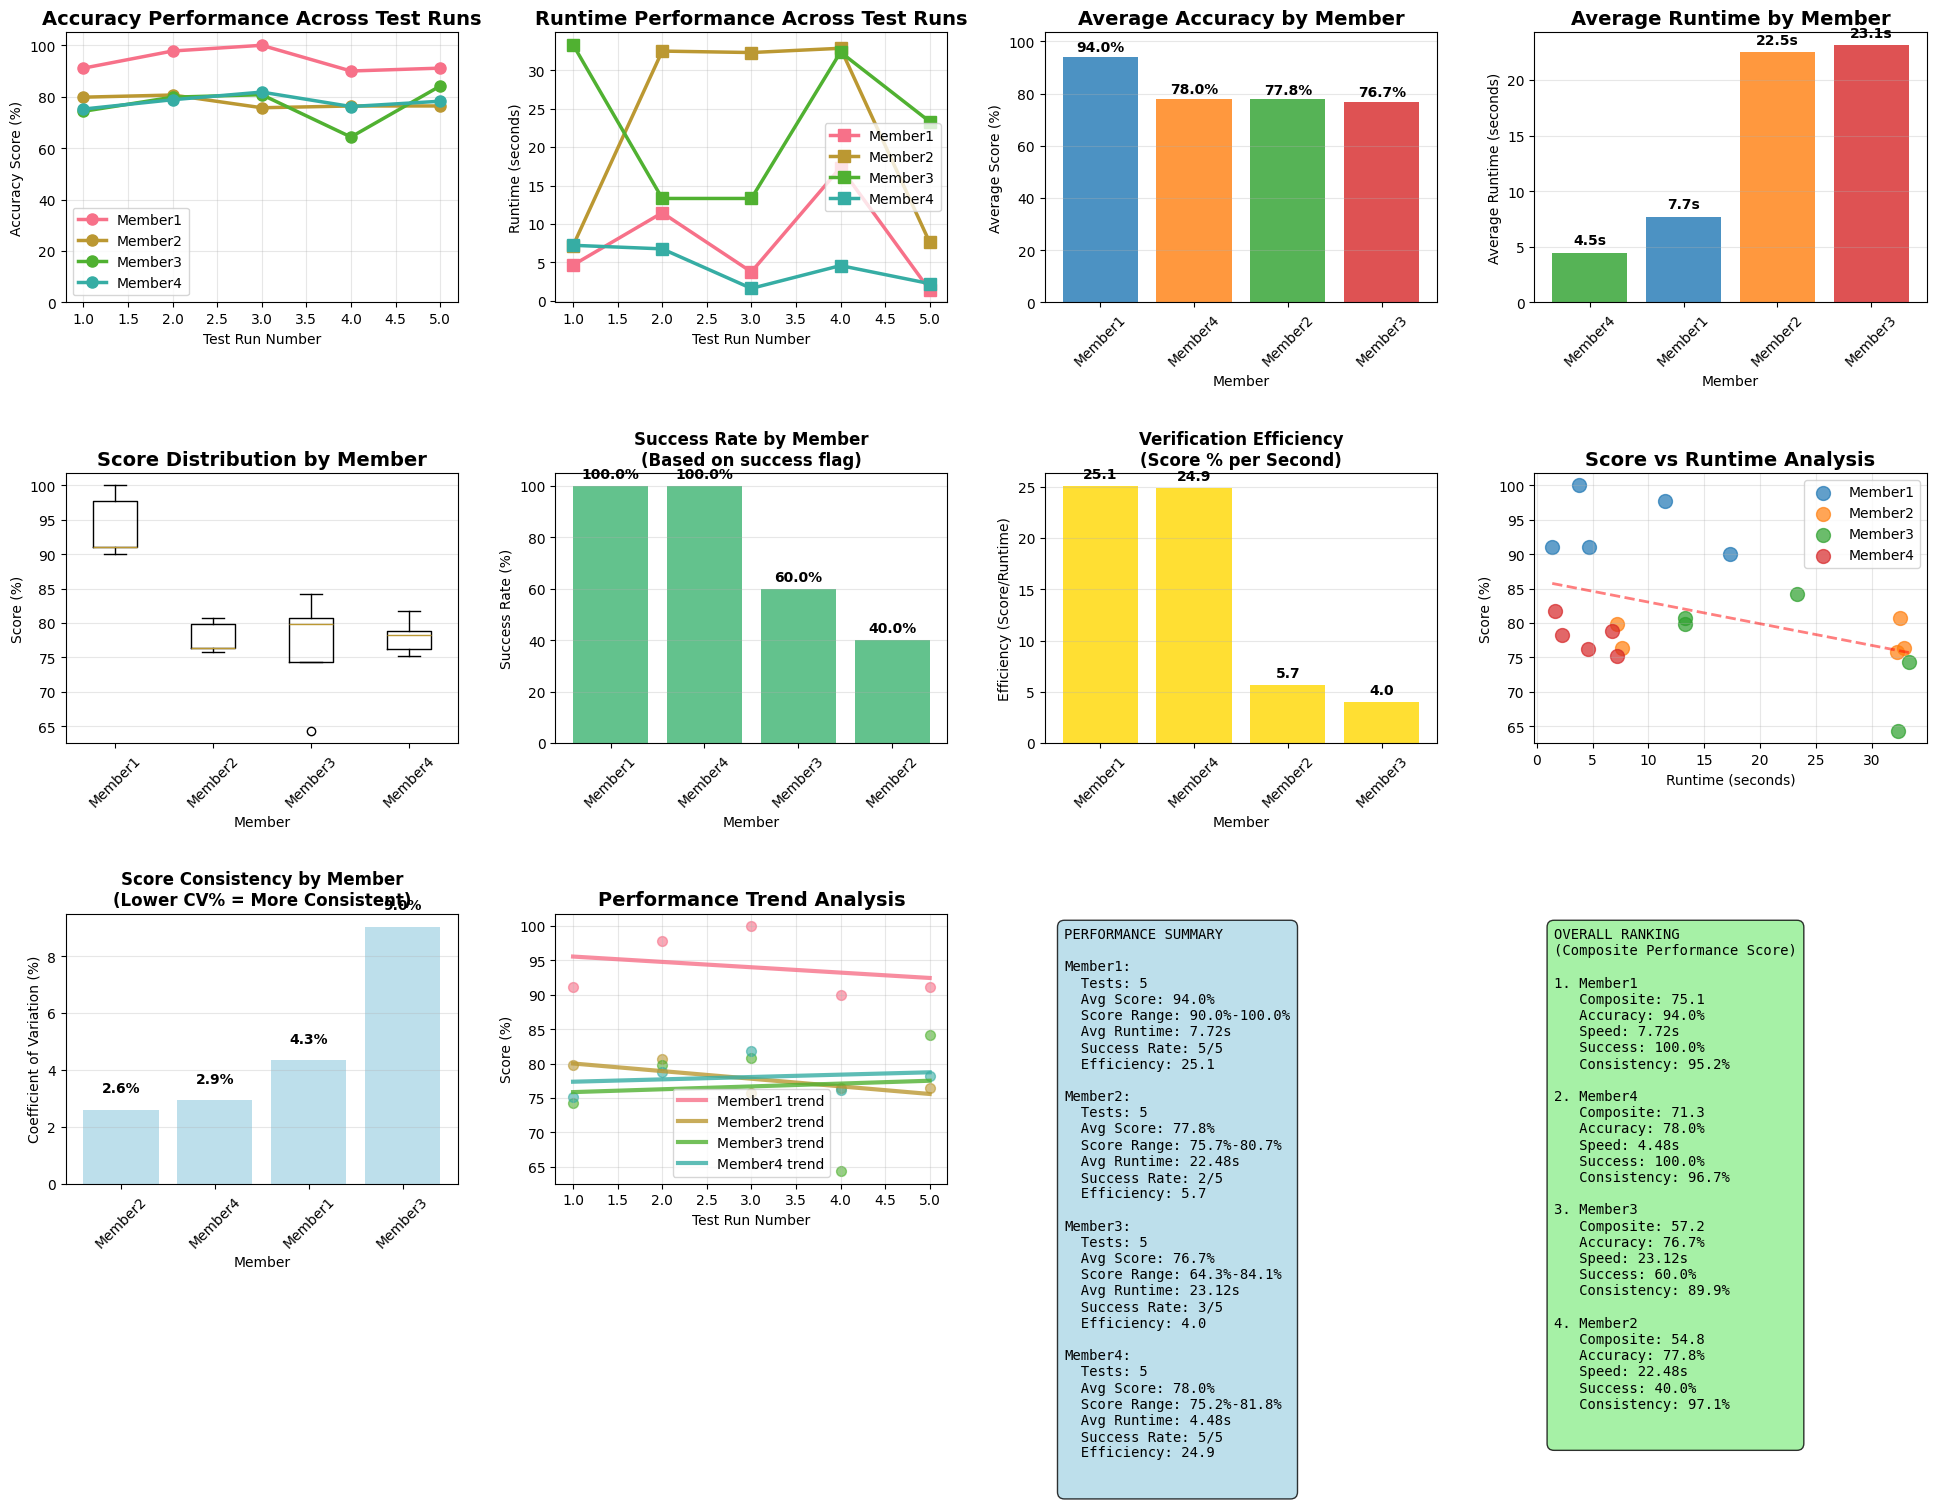

VERIFICATION SYSTEM ANALYSIS REPORT

DATASET OVERVIEW:
  Total Test Runs: 20
  Number of Members: 4
  Number of Students: 1
  Students Tested: S002
  Data Collection Period: 2025-08-30 13:48 to 2025-08-30 14:08

SYSTEM-WIDE PERFORMANCE:
  Average Accuracy: 81.63% (±8.57%)
  Average Runtime: 14.453s (±12.052s)
  Overall Success Rate: 75.0%
  Best Single Performance: 100.0%
  Fastest Single Run: 1.389s

MEMBER PERFORMANCE ANALYSIS:
--------------------------------------------------

Member1:
  Test Runs: 5
  Average Score: 94.00% (±4.56%)
  Score Range: 90.0% - 100.0%
  Average Runtime: 7.722s (±6.550s)
  Success Rate: 5/5 (100.0%)
  Efficiency: 25.08 points/second
  Consistency: High (CV: 4.8%)

Member2:
  Test Runs: 5
  Average Score: 77.80% (±2.26%)
  Score Range: 75.7% - 80.7%
  Average Runtime: 22.485s (±13.778s)
  Success Rate: 2/5 (40.0%)
  Efficiency: 5.66 points/second
  Consistency: High (CV: 2.9%)

Member3:
  Test Runs: 5
  Average Score: 76.68% (±7.75%)
  Score Range: 64.3% -

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import numpy as np
from pathlib import Path
from datetime import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


class ComprehensiveResultsAnalyzer:
    """
    Improved analyzer for multi-member verification system results.
    """
    
    def __init__(self, results_directory: str = "results"):
        self.results_dir = Path(results_directory)
        self.results_file = self.results_dir / "all_results.json"
    
    def ensure_file_exists(self):
        """Ensure the results file exists"""
        if not self.results_file.exists():
            raise FileNotFoundError(f"Results file not found at {self.results_file}")
    
    def load_results_dataframe(self, data: list = None) -> pd.DataFrame:
        """Load results from file or provided data into a comprehensive DataFrame"""
        if data is not None:
            df = pd.DataFrame(data)
        else:
            self.ensure_file_exists()
            try:
                with open(self.results_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                df = pd.DataFrame(data)
            except Exception as e:
                print(f"Error loading results: {e}")
                return pd.DataFrame()
        
        # Data preprocessing
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['score_percentage'] = df['score'] * 100
        df['efficiency'] = df['score_percentage'] / df['runtime']
        
        return df
    
    def generate_comprehensive_analysis(self, data: list = None, save_plots: bool = True):
        """
        Generate comprehensive analysis supporting both single and multi-student scenarios.
        """
        df = self.load_results_dataframe(data)
        
        if df.empty:
            print("No data available for analysis!")
            return
        
        # Set plotting style
        plt.style.use('default')
        sns.set_palette("husl")
        
        # Determine analysis scope
        num_students = df['student_id'].nunique()
        num_members = df['member'].nunique()
        
        print(f"Analyzing data for {num_students} student(s) and {num_members} member(s)")
        
        # Create adaptive figure layout
        if num_students == 1:
            fig = plt.figure(figsize=(20, 15))
            self._create_single_student_analysis(df, fig)
        else:
            fig = plt.figure(figsize=(24, 18))
            self._create_multi_student_analysis(df, fig)
        
        plt.tight_layout(pad=3.0)
        
        if save_plots:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f'verification_analysis_{num_students}students_{timestamp}.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Analysis saved as '{filename}'")
        
        plt.show()
        return df
    
    def _create_single_student_analysis(self, df, fig):
        """Create plots optimized for single student analysis"""
        
        # 1. Accuracy Performance Over Test Runs
        plt.subplot(3, 4, 1)
        for member in sorted(df['member'].unique()):
            member_data = df[df['member'] == member].sort_values('test_run')
            plt.plot(member_data['test_run'], member_data['score_percentage'], 
                    marker='o', linewidth=2.5, label=member, markersize=8)
        
        plt.title('Accuracy Performance Across Test Runs', fontsize=14, fontweight='bold')
        plt.xlabel('Test Run Number')
        plt.ylabel('Accuracy Score (%)')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.ylim(0, 105)
        
        # 2. Runtime Performance Over Test Runs
        plt.subplot(3, 4, 2)
        for member in sorted(df['member'].unique()):
            member_data = df[df['member'] == member].sort_values('test_run')
            plt.plot(member_data['test_run'], member_data['runtime'], 
                    marker='s', linewidth=2.5, label=member, markersize=8)
        
        plt.title('Runtime Performance Across Test Runs', fontsize=14, fontweight='bold')
        plt.xlabel('Test Run Number')
        plt.ylabel('Runtime (seconds)')
        plt.legend()
        plt.grid(alpha=0.3)
        
        # 3. Average Performance Comparison
        plt.subplot(3, 4, 3)
        avg_scores = df.groupby('member')['score_percentage'].mean().sort_values(ascending=False)
        
        bars = plt.bar(range(len(avg_scores)), avg_scores.values, 
                      alpha=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(avg_scores)])
        plt.title('Average Accuracy by Member', fontsize=14, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Average Score (%)')
        plt.xticks(range(len(avg_scores)), avg_scores.index, rotation=45)
        
        # Add value labels
        for i, (bar, value) in enumerate(zip(bars, avg_scores.values)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        plt.ylim(0, max(avg_scores.values) * 1.1)
        
        # 4. Average Runtime Comparison
        plt.subplot(3, 4, 4)
        avg_runtime = df.groupby('member')['runtime'].mean().sort_values()
        
        bars = plt.bar(range(len(avg_runtime)), avg_runtime.values, 
                      alpha=0.8, color=['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728'][:len(avg_runtime)])
        plt.title('Average Runtime by Member', fontsize=14, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Average Runtime (seconds)')
        plt.xticks(range(len(avg_runtime)), avg_runtime.index, rotation=45)
        
        for i, (bar, value) in enumerate(zip(bars, avg_runtime.values)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.1f}s', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # 5. Score Distribution Box Plot
        plt.subplot(3, 4, 5)
        member_scores = [df[df['member'] == member]['score_percentage'].values 
                        for member in sorted(df['member'].unique())]
        plt.boxplot(member_scores, labels=sorted(df['member'].unique()))
        plt.title('Score Distribution by Member', fontsize=14, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Score (%)')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        
        # 6. Success Rate Analysis
        plt.subplot(3, 4, 6)
        success_threshold = 75  # Success threshold
        success_rates = df.groupby('member').apply(
            lambda x: (x['success'] == True).sum() / len(x) * 100
        ).sort_values(ascending=False)
        
        bars = plt.bar(range(len(success_rates)), success_rates.values, 
                      alpha=0.8, color='mediumseagreen')
        plt.title(f'Success Rate by Member\n(Based on success flag)', fontsize=12, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Success Rate (%)')
        plt.xticks(range(len(success_rates)), success_rates.index, rotation=45)
        
        for i, (bar, rate) in enumerate(zip(bars, success_rates.values)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                    f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        plt.ylim(0, 105)
        
        # 7. Efficiency Analysis (Score per Second)
        plt.subplot(3, 4, 7)
        avg_efficiency = df.groupby('member')['efficiency'].mean().sort_values(ascending=False)
        
        bars = plt.bar(range(len(avg_efficiency)), avg_efficiency.values, 
                      alpha=0.8, color='gold')
        plt.title('Verification Efficiency\n(Score % per Second)', fontsize=12, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Efficiency (Score/Runtime)')
        plt.xticks(range(len(avg_efficiency)), avg_efficiency.index, rotation=45)
        
        for i, (bar, value) in enumerate(zip(bars, avg_efficiency.values)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # 8. Performance vs Runtime Scatter
        plt.subplot(3, 4, 8)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        for i, member in enumerate(sorted(df['member'].unique())):
            member_data = df[df['member'] == member]
            plt.scatter(member_data['runtime'], member_data['score_percentage'],
                       label=member, alpha=0.7, s=100, color=colors[i % len(colors)])
        
        plt.title('Score vs Runtime Analysis', fontsize=14, fontweight='bold')
        plt.xlabel('Runtime (seconds)')
        plt.ylabel('Score (%)')
        plt.legend()
        plt.grid(alpha=0.3)
        
        # Add trend line
        plt.plot(np.unique(df['runtime']), 
                np.poly1d(np.polyfit(df['runtime'], df['score_percentage'], 1))(np.unique(df['runtime'])),
                '--', color='red', alpha=0.5, linewidth=2)
        
        # 9. Consistency Analysis
        plt.subplot(3, 4, 9)
        consistency_stats = df.groupby('member').agg({
            'score_percentage': lambda x: (np.std(x) / np.mean(x)) * 100 if np.mean(x) > 0 else 0
        })['score_percentage'].sort_values()
        
        bars = plt.bar(range(len(consistency_stats)), consistency_stats.values, 
                      alpha=0.8, color='lightblue')
        plt.title('Score Consistency by Member\n(Lower CV% = More Consistent)', 
                 fontsize=12, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Coefficient of Variation (%)')
        plt.xticks(range(len(consistency_stats)), consistency_stats.index, rotation=45)
        
        for i, (bar, value) in enumerate(zip(bars, consistency_stats.values)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # 10. Performance Trends (if enough data)
        plt.subplot(3, 4, 10)
        for member in sorted(df['member'].unique()):
            member_data = df[df['member'] == member].sort_values('test_run')
            if len(member_data) >= 3:
                # Calculate trend
                z = np.polyfit(member_data['test_run'], member_data['score_percentage'], 1)
                p = np.poly1d(z)
                plt.plot(member_data['test_run'], p(member_data['test_run']), 
                        linewidth=3, label=f'{member} trend', alpha=0.8)
                plt.scatter(member_data['test_run'], member_data['score_percentage'], 
                           alpha=0.6, s=50)
        
        plt.title('Performance Trend Analysis', fontsize=14, fontweight='bold')
        plt.xlabel('Test Run Number')
        plt.ylabel('Score (%)')
        plt.legend()
        plt.grid(alpha=0.3)
        
        # 11. Statistical Summary Table
        plt.subplot(3, 4, 11)
        plt.axis('off')
        
        stats_summary = df.groupby('member').agg({
            'score_percentage': ['mean', 'std', 'min', 'max'],
            'runtime': ['mean', 'std'],
            'test_run': 'count',
            'success': lambda x: (x == True).sum()
        }).round(2)
        
        table_text = "PERFORMANCE SUMMARY\n\n"
        for member in sorted(df['member'].unique()):
            member_data = df[df['member'] == member]
            table_text += f"{member}:\n"
            table_text += f"  Tests: {len(member_data)}\n"
            table_text += f"  Avg Score: {member_data['score_percentage'].mean():.1f}%\n"
            table_text += f"  Score Range: {member_data['score_percentage'].min():.1f}%-{member_data['score_percentage'].max():.1f}%\n"
            table_text += f"  Avg Runtime: {member_data['runtime'].mean():.2f}s\n"
            table_text += f"  Success Rate: {(member_data['success'] == True).sum()}/{len(member_data)}\n"
            table_text += f"  Efficiency: {member_data['efficiency'].mean():.1f}\n\n"
        
        plt.text(0.05, 0.95, table_text, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8),
                family='monospace')
        
        # 12. Member Ranking
        plt.subplot(3, 4, 12)
        plt.axis('off')
        
        # Calculate composite performance score
        member_rankings = []
        for member in df['member'].unique():
            member_data = df[df['member'] == member]
            avg_score = member_data['score_percentage'].mean()
            avg_runtime = member_data['runtime'].mean()
            success_rate = (member_data['success'] == True).mean() * 100
            consistency = 100 - ((member_data['score_percentage'].std() / avg_score) * 100) if avg_score > 0 else 0
            
            # Composite score (weighted: 40% accuracy, 25% speed, 20% success rate, 15% consistency)
            speed_score = 100 / avg_runtime if avg_runtime > 0 else 0
            composite = (avg_score * 0.4) + (speed_score * 0.25) + (success_rate * 0.2) + (consistency * 0.15)
            
            member_rankings.append({
                'member': member,
                'composite_score': composite,
                'avg_score': avg_score,
                'avg_runtime': avg_runtime,
                'success_rate': success_rate,
                'consistency': consistency
            })
        
        # Sort by composite score
        member_rankings.sort(key=lambda x: x['composite_score'], reverse=True)
        
        ranking_text = "OVERALL RANKING\n(Composite Performance Score)\n\n"
        for i, perf in enumerate(member_rankings, 1):
            ranking_text += f"{i}. {perf['member']}\n"
            ranking_text += f"   Composite: {perf['composite_score']:.1f}\n"
            ranking_text += f"   Accuracy: {perf['avg_score']:.1f}%\n"
            ranking_text += f"   Speed: {perf['avg_runtime']:.2f}s\n"
            ranking_text += f"   Success: {perf['success_rate']:.1f}%\n"
            ranking_text += f"   Consistency: {perf['consistency']:.1f}%\n\n"
        
        plt.text(0.05, 0.95, ranking_text, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8),
                family='monospace')
    
    def _create_multi_student_analysis(self, df, fig):
        """Create plots optimized for multi-student analysis"""
        
        # 1. Overall Performance by Student
        plt.subplot(3, 5, 1)
        student_avg = df.groupby('student_id')['score_percentage'].mean().sort_values(ascending=False)
        bars = plt.bar(range(len(student_avg)), student_avg.values, alpha=0.8, color='skyblue')
        plt.title('Average Performance by Student', fontsize=12, fontweight='bold')
        plt.xlabel('Student ID')
        plt.ylabel('Average Score (%)')
        plt.xticks(range(len(student_avg)), student_avg.index, rotation=45)
        
        for bar, value in zip(bars, student_avg.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # 2. Member Performance Across All Students
        plt.subplot(3, 5, 2)
        member_avg = df.groupby('member')['score_percentage'].mean().sort_values(ascending=False)
        bars = plt.bar(range(len(member_avg)), member_avg.values, alpha=0.8, color='lightcoral')
        plt.title('Average Member Performance\n(All Students)', fontsize=12, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Average Score (%)')
        plt.xticks(range(len(member_avg)), member_avg.index, rotation=45)
        
        for bar, value in zip(bars, member_avg.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # 3. Heatmap: Member vs Student Performance
        plt.subplot(3, 5, 3)
        pivot_scores = df.pivot_table(values='score_percentage', 
                                     index='member', columns='student_id', aggfunc='mean')
        sns.heatmap(pivot_scores, annot=True, fmt='.1f', cmap='RdYlGn', 
                   cbar_kws={'label': 'Average Score (%)'})
        plt.title('Member-Student Performance Matrix', fontsize=12, fontweight='bold')
        plt.xlabel('Student ID')
        plt.ylabel('Member')
        
        # 4. Runtime Efficiency by Student
        plt.subplot(3, 5, 4)
        student_runtime = df.groupby('student_id')['runtime'].mean().sort_values()
        bars = plt.bar(range(len(student_runtime)), student_runtime.values, alpha=0.8, color='orange')
        plt.title('Average Runtime by Student', fontsize=12, fontweight='bold')
        plt.xlabel('Student ID')
        plt.ylabel('Average Runtime (s)')
        plt.xticks(range(len(student_runtime)), student_runtime.index, rotation=45)
        
        for bar, value in zip(bars, student_runtime.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.1f}s', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # 5. Success Rate Heatmap
        plt.subplot(3, 5, 5)
        pivot_success = df.pivot_table(values='success', 
                                      index='member', columns='student_id', 
                                      aggfunc=lambda x: (x == True).mean() * 100)
        sns.heatmap(pivot_success, annot=True, fmt='.0f', cmap='RdYlGn', 
                   cbar_kws={'label': 'Success Rate (%)'})
        plt.title('Success Rate Matrix', fontsize=12, fontweight='bold')
        plt.xlabel('Student ID')
        plt.ylabel('Member')
        
        # 6-10. Individual student detailed analysis (if <= 4 students)
        students = sorted(df['student_id'].unique())
        if len(students) <= 4:
            for idx, student in enumerate(students[:4]):
                plt.subplot(3, 5, 6 + idx)
                student_data = df[df['student_id'] == student]
                
                for member in sorted(student_data['member'].unique()):
                    member_student_data = student_data[student_data['member'] == member].sort_values('test_run')
                    plt.plot(member_student_data['test_run'], member_student_data['score_percentage'],
                            marker='o', linewidth=2, label=member, markersize=6)
                
                plt.title(f'Performance for {student}', fontsize=12, fontweight='bold')
                plt.xlabel('Test Run')
                plt.ylabel('Score (%)')
                plt.legend()
                plt.grid(alpha=0.3)
                plt.ylim(0, 105)
        
        # 11. Overall Statistics
        plt.subplot(3, 5, 11)
        plt.axis('off')
        
        overall_stats = f"""OVERALL STATISTICS
        
Total Test Runs: {len(df)}
Students Tested: {df['student_id'].nunique()}
Members Evaluated: {df['member'].nunique()}

SYSTEM PERFORMANCE:
Average Score: {df['score_percentage'].mean():.1f}%
Average Runtime: {df['runtime'].mean():.2f}s
Overall Success Rate: {(df['success'] == True).mean() * 100:.1f}%

BEST PERFORMANCE:
Highest Score: {df['score_percentage'].max():.1f}%
Fastest Runtime: {df['runtime'].min():.2f}s
Most Efficient: {df['efficiency'].max():.1f} pts/s
"""
        
        plt.text(0.05, 0.95, overall_stats, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8),
                family='monospace')
        
        # 12-15. Additional analysis plots for remaining slots
        if len(students) > 4:
            # Show aggregated student comparison if too many students
            plt.subplot(3, 5, 12)
            df.boxplot(column='score_percentage', by='student_id', ax=plt.gca())
            plt.title('Score Distribution Across All Students')
            plt.xlabel('Student ID')
            plt.ylabel('Score (%)')
            plt.suptitle('')
            plt.xticks(rotation=45)
    
    def print_detailed_analysis(self, data: list = None):
        """Print comprehensive statistical analysis"""
        df = self.load_results_dataframe(data)
        
        if df.empty:
            print("No data available for analysis!")
            return
        
        print("=" * 80)
        print("VERIFICATION SYSTEM ANALYSIS REPORT")
        print("=" * 80)
        
        # Dataset Overview
        print(f"\nDATASET OVERVIEW:")
        print(f"  Total Test Runs: {len(df)}")
        print(f"  Number of Members: {df['member'].nunique()}")
        print(f"  Number of Students: {df['student_id'].nunique()}")
        print(f"  Students Tested: {', '.join(sorted(df['student_id'].unique()))}")
        print(f"  Data Collection Period: {df['timestamp'].min().strftime('%Y-%m-%d %H:%M')} to {df['timestamp'].max().strftime('%Y-%m-%d %H:%M')}")
        
        # Overall System Performance
        print(f"\nSYSTEM-WIDE PERFORMANCE:")
        print(f"  Average Accuracy: {df['score_percentage'].mean():.2f}% (±{df['score_percentage'].std():.2f}%)")
        print(f"  Average Runtime: {df['runtime'].mean():.3f}s (±{df['runtime'].std():.3f}s)")
        print(f"  Overall Success Rate: {(df['success'] == True).mean() * 100:.1f}%")
        print(f"  Best Single Performance: {df['score_percentage'].max():.1f}%")
        print(f"  Fastest Single Run: {df['runtime'].min():.3f}s")
        
        # Member Analysis
        print(f"\nMEMBER PERFORMANCE ANALYSIS:")
        print("-" * 50)
        
        for member in sorted(df['member'].unique()):
            member_data = df[df['member'] == member]
            
            print(f"\n{member}:")
            print(f"  Test Runs: {len(member_data)}")
            print(f"  Average Score: {member_data['score_percentage'].mean():.2f}% (±{member_data['score_percentage'].std():.2f}%)")
            print(f"  Score Range: {member_data['score_percentage'].min():.1f}% - {member_data['score_percentage'].max():.1f}%")
            print(f"  Average Runtime: {member_data['runtime'].mean():.3f}s (±{member_data['runtime'].std():.3f}s)")
            print(f"  Success Rate: {(member_data['success'] == True).sum()}/{len(member_data)} ({(member_data['success'] == True).mean() * 100:.1f}%)")
            print(f"  Efficiency: {member_data['efficiency'].mean():.2f} points/second")
            
            # Consistency metrics
            score_cv = (member_data['score_percentage'].std() / member_data['score_percentage'].mean()) * 100
            consistency_rating = "High" if score_cv < 10 else "Medium" if score_cv < 20 else "Low"
            print(f"  Consistency: {consistency_rating} (CV: {score_cv:.1f}%)")
        
        # Student-specific Analysis (if multiple students)
        if df['student_id'].nunique() > 1:
            print(f"\nSTUDENT-SPECIFIC ANALYSIS:")
            print("-" * 50)
            
            for student in sorted(df['student_id'].unique()):
                student_data = df[df['student_id'] == student]
                
                print(f"\n{student}:")
                print(f"  Test Runs: {len(student_data)} (across {student_data['member'].nunique()} members)")
                print(f"  Average Score: {student_data['score_percentage'].mean():.2f}%")
                print(f"  Average Runtime: {student_data['runtime'].mean():.3f}s")
                print(f"  Success Rate: {(student_data['success'] == True).mean() * 100:.1f}%")
                
                # Best and worst performing members for this student
                member_performance = student_data.groupby('member')['score_percentage'].mean()
                best_member = member_performance.idxmax()
                worst_member = member_performance.idxmin()
                print(f"  Best Member: {best_member} ({member_performance[best_member]:.1f}%)")
                print(f"  Worst Member: {worst_member} ({member_performance[worst_member]:.1f}%)")
        
        # Performance Insights
        print(f"\nKEY INSIGHTS:")
        print("-" * 50)
        
        # Best performers
        best_accuracy_member = df.groupby('member')['score_percentage'].mean().idxmax()
        fastest_member = df.groupby('member')['runtime'].mean().idxmin()
        most_consistent = df.groupby('member').apply(
            lambda x: (x['score_percentage'].std() / x['score_percentage'].mean()) * 100
        ).idxmin()
        
        print(f"  Most Accurate Member: {best_accuracy_member}")
        print(f"  Fastest Member: {fastest_member}")
        print(f"  Most Consistent Member: {most_consistent}")
        
        # System recommendations
        print(f"\nRECOMMENDations:")
        print("-" * 50)
        
        avg_runtime = df['runtime'].mean()
        if avg_runtime > 20:
            print("  • Consider optimizing runtime - average exceeds 20 seconds")
        
        success_rate = (df['success'] == True).mean()
        if success_rate < 0.8:
            print("  • Low success rate detected - investigate failing test cases")
        
        score_variance = df.groupby('member')['score_percentage'].std().max()
        if score_variance > 15:
            print("  • High score variance detected - investigate consistency issues")
        
        if df['member'].nunique() > 1:
            # Statistical significance between members
            members = list(df['member'].unique())
            if len(members) >= 2:
                member1_scores = df[df['member'] == members[0]]['score_percentage']
                member2_scores = df[df['member'] == members[1]]['score_percentage']
                
                if len(member1_scores) > 1 and len(member2_scores) > 1:
                    t_stat, p_value = stats.ttest_ind(member1_scores, member2_scores)
                    if p_value < 0.05:
                        print(f"  • Significant performance difference detected between {members[0]} and {members[1]} (p={p_value:.3f})")
        
        return df

# Example usage functions
def analyze_results_from_data(data_list: list):
    """
    Analyze results from provided data list
    """
    analyzer = ComprehensiveResultsAnalyzer()
    
    print("Starting comprehensive analysis...")
    df = analyzer.generate_comprehensive_analysis(data=data_list)
    analyzer.print_detailed_analysis(data=data_list)
    
    return df

def analyze_results_from_file():
    """
    Analyze results from stored JSON file
    """
    analyzer = ComprehensiveResultsAnalyzer()
    
    print("Loading results from file...")
    df = analyzer.generate_comprehensive_analysis()
    analyzer.print_detailed_analysis()
    
    return df

def quick_summary(data_list: list = None):
    """
    Generate quick summary statistics without plots
    """
    analyzer = ComprehensiveResultsAnalyzer()
    df = analyzer.load_results_dataframe(data_list)
    
    if df.empty:
        print("No data available!")
        return
    
    print("\nQUICK SUMMARY REPORT")
    print("=" * 40)
    
    # Overall metrics
    print(f"Total Tests: {len(df)}")
    print(f"Students: {df['student_id'].nunique()}")
    print(f"Members: {df['member'].nunique()}")
    print(f"Average Score: {df['score_percentage'].mean():.1f}%")
    print(f"Average Runtime: {df['runtime'].mean():.2f}s")
    print(f"Success Rate: {(df['success'] == True).mean() * 100:.1f}%")
    
    # Top performers
    print(f"\nTOP PERFORMERS:")
    best_member = df.groupby('member')['score_percentage'].mean().idxmax()
    fastest_member = df.groupby('member')['runtime'].mean().idxmin()
    print(f"Best Average Score: {best_member}")
    print(f"Fastest Average Runtime: {fastest_member}")
    
    return df

# Initialize the analyzer
analyzer = ComprehensiveResultsAnalyzer()
print("Multi-Student Verification System Analyzer Ready")

# Example usage with your sample data
if __name__ == "__main__":
    # Initialize analyzer with current directory
    analyzer = ComprehensiveResultsAnalyzer()
    
    # Load and analyze results from all_results.json
    print("Loading results from all_results.json...")
    df = analyzer.generate_comprehensive_analysis()
    analyzer.print_detailed_analysis()